# Offline bot classification using ANTE

## Introduction

The goal is to classify traffic between devices into two different groups: bot or non-bot. This task is considered as a binary classification problem, where 0 indicates that traffic is caused by a bot, and 1 otherwise.

This analysis uses the CTU-13 dataset. This dataset captures both malicious (generated by bots) and normal network traffic recorded at the Czech Technical University. This analysis specifically uses capture 51, characterized by its large volume of data, totalizing 64GB.

In [1]:
dataset = "../../data/raw/CTU-datasets/botnet-capture-20110818-bot-2.csv"

The dataset is too large to include in the repository, so a small sample is used to visualize all the dataset columns

In [2]:
import pandas as pd
sample = pd.read_csv("../../data/raw/CTU-datasets/sample.csv", sep=";")
sample.head(5)

,frame.time,frame.time_epoch,_ws.col.Source,_ws.col.Destination,_ws.col.Protocol,frame.len
0,"Aug 18, 2011 10:46:56.445440000 -03",1.313675e+09,Cisco_db:19:c3,147.32.84.191,ARP,60
1,"Aug 18, 2011 10:47:47.832016000 -03",1.313675e+09,PcsCompu_b5:b7:19,147.32.84.191,ARP,60
2,"Aug 18, 2011 10:47:47.832023000 -03",1.313675e+09,147.32.84.255,Broadcast,ARP,60
3,"Aug 18, 2011 10:47:48.820312000 -03",1.313675e+09,147.32.84.255,147.32.84.191,ARP,60
4,"Aug 18, 2011 10:47:48.820320000 -03",1.313675e+09,147.32.84.255,147.32.84.191,ARP,60


Each line is a network packet exchanged between devices. The column <b>"_ws.col.Source"</b> represents the source of the packet and <b>"_ws.col.Destination"</b>  its destination. The size of the packet can be found in the column <b>"frame.len"</b>. If either the source or the destination is a bot, the packet is considered malicious.

In [3]:
bots = ["147.32.84.191", "147.32.84.165"]

For this analysis, the dataset is split into two segments. The first segment is composed of the initial moments of the capture.  In this segment, the network traffic is low, and most of the bots are exchanging just a few messages. In the second segment, the network traffic rises exponentially, caused by an increase in packets sent by bots.

In [4]:
from dateutil import parser
training_segment_bounds = parser.parse("2011-08-18T10:48:00"), parser.parse("2011-08-18T10:50:01")
testing_segment_bounds = parser.parse("2011-08-18T10:50:01"), parser.parse("2011-08-18T10:55:00")


The dramatic change in network behavior between the two segments is characterized by a change in data distribution. ANTE is used to autonomously detect this change and adapt its classification pipeline. In this analysis, the change is done by simulating a streaming environment. The initial classification pipeline is optimized using the first segment. The second segment is consumed in batches.

## ANTE building block

All data operations used by ANTE are build using the same basic building block, illustrated in the figure below.


<img src="images/antecomponent.jpg" width="600" height="600" />

This component is used to represent a classifier, a feature preprocessor, or any component responsible for data transformations.


## Creating the feature pipeline


The network traffic is classified using a bag of features approach. Firstly, all network packets are grouped using a sliding window.  Secondly,  a vector of features is calculated for every window. Subsequently, the feature vector is used as input of a classifier.


The feature pipeline is illustrated in the figure below.

<img src="images/featurepipeline.jpg" width="900" height="900" />

In [5]:
#enable caching for feature pipeline results
import prefect
prefect.context.config.flows.checkpointing = True
#ignore warnings
import logging
logging.getLogger("prefect").setLevel(logging.ERROR)

In [6]:
from ante.pipelines.featurepipeline import FeaturesPipeline
window_size = 30
window_offset = 5
feature_pipeline = FeaturesPipeline()

In [7]:
from functools import partial
run_feature_pipeline = partial(
    feature_pipeline.run, 
    dataset=dataset,
    bots=bots,
    window_size=window_size,
    window_offset=window_offset
)

In [8]:
training_segment_data = run_feature_pipeline(
    start_date=training_segment_bounds[0].timestamp(),
    end_date=training_segment_bounds[1].timestamp()
);

#removes pyspark output for brevity
from IPython.display import clear_output
clear_output()

In [9]:
#features 
training_segment_data.dtypes

IP                         object
Spc                       float64
Tss                       float64
Smin                      float64
Smax                      float64
Savg                      float64
Svar                      float64
SITmin                    float64
SITmax                    float64
SITavg                    float64
SITvar                    float64
Rpc                       float64
Tsr                       float64
Ravg                      float64
Rvar                      float64
RITmin                    float64
RITmax                    float64
RITavg                    float64
RITvar                    float64
in_degree                 float64
out_degree                float64
centrality                float64
eigenvector_centrality    float64
window_start               object
window_end                 object
window_index                int64
isBot                       int64
dtype: object

In [10]:
testing_segment = run_feature_pipeline(
    start_date=testing_segment_bounds[0].timestamp(),
    end_date=testing_segment_bounds[1].timestamp()
)
testing_segment["window_start"] = pd.to_datetime(testing_segment['window_start'])

#removes pyspark output for brevity
clear_output()

## Creating the classification pipeline

Ante autonomously optimizes a classification pipeline using AutoML

<img src="images/automl.jpg" width=900 height=900 />

In [11]:
from ante.pipelines.classificationpipeline import MetaClassificationPipeline
meta_classification_pipeline = MetaClassificationPipeline(time_limit=60)

The feature pipeline and the classification are combined into a single final pipeline.

<img src="images/finalpipeline.jpg" width=900 height=900 />

In [12]:
def remove_meta_columns(df):
    return df.drop(['IP', 'isBot', 'window_start', 'window_end', 'window_index'], axis=1)

training_segment_x, training_segment_y = remove_meta_columns(training_segment_data), training_segment_data["isBot"]
classification_pipeline = meta_classification_pipeline.run(training_segment_x, training_segment_y)

#removes output for brevity
clear_output()

## Adapting to changes

The final piece of the ANTE framework is the drift detector. This component is responsible for detecting changes in the data distribution and adapting the classification pipeline

<img src="images/ante.jpg" width=900 height=900 />

In this analysis, a streaming environment is simulated by feeding batches of data from the testing segment. If the nature of the data observed by the drift detector is different from the data in which the current classification pipeline was optimized, the drift detector triggers a change in the classification pipeline

In [13]:
from sklearn.metrics import accuracy_score
from ante.driftdetection.ensemble import ClusterMetricsEnsembleDriftDetector
from ante.util import sliding_window


drift_detector = ClusterMetricsEnsembleDriftDetector()
drift_detector.set_reference_concept(training_segment_x.copy(deep=True))

run_statistics = []

for batch_start, batch_end, batch_data in sliding_window(testing_segment, "window_start", "60s", "1s"):
    if batch_data.shape[0] > 1:
        batch_data_y = batch_data['isBot']
        batch_data_x = remove_meta_columns(batch_data).copy().reset_index(drop=True)

        drift_detection, essemble_predictions = drift_detector.fit_predict([batch_data_x])
        #if there was a change in the data distribution
        if drift_detection == 1:
            #replace the classification pipeline
            classification_pipeline = meta_classification_pipeline.run(batch_data_x, batch_data_y)
            #set the new 'normal'
            drift_detector.set_reference_concept(batch_data_x.copy(deep=True))
    
        batch_data_y_hat = classification_pipeline.run(batch_data_x)
        accuracy = accuracy_score(batch_data_y, batch_data_y_hat)
  
        run_statistics.append({
            "drift_detection": drift_detection,
            "batch_start": batch_start,
            "batch_end": batch_end,
            "accuracy": accuracy,
        })
run_statistics = pd.DataFrame.from_records(run_statistics)

#removes output for brevity
clear_output()

In the image below, we can see the work of the drift detector. The dashed squares mark the places where the drift detector was triggered. When the accuracy drops the classification pipeline is replaced, resulting in better accuracy

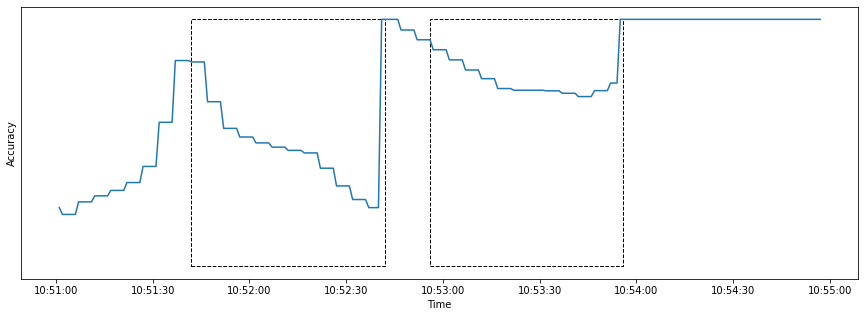

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import timedelta
fig, ax = plt.subplots(figsize=(15, 5))
ax.yaxis.set_ticks([])
plt.plot(run_statistics["batch_end"], run_statistics["accuracy"])


drift_regions = run_statistics[run_statistics["drift_detection"] == 1]
for region in drift_regions.to_dict('records'):
    ax.add_patch(
     patches.Rectangle(
        (region['batch_start'], 0.8),
        timedelta(seconds=60),
        0.2,
        facecolor = 'gray',
        linestyle='--',
        fill=False 
     ) ) 
            
plt.ylabel('Accuracy')
plt.xlabel('Time')
plt.show()